<a href="https://colab.research.google.com/github/TongHere/AI-Project/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the dataset

##The detection of fraudulent credit card transactions is crucial for ensuring customer safety. However, the dataset used to train the logistic regression classification model is highly imbalanced, with only 0.172% of transactions belonging to the positive class (i.e., frauds). This dataset includes transactions conducted by European cardholders in September 2013. Additionally, the features V1 to V28 have been anonymized and scaled to maintain confidentiality.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.8 MB/s eta 0:00:00


#Set Up 

In [30]:
import gc
from datetime import datetime 
starttime= datetime.now()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 4686

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from warnings import simplefilter
# Ignore warnings
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

print("setup complete.")

setup complete.


# Load the dataset

In [31]:
filepath = "/content/creditcard.csv"

In [32]:
data_df = pd.read_csv(filepath)

##Features V1 to V28 are not the original features and they are also scaled due to confidentiality issues

In [33]:
data_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97137,66085,0.998571,-0.046655,0.644378,1.114925,-0.665698,-0.627024,-0.002057,0.018110,-0.052156,0.120975,1.419839,0.582597,-0.929904,0.702023,0.466518,0.482263,-0.625154,0.205809,-0.091239,-0.016987,-0.171808,-0.784227,0.095822,0.455048,0.167887,-0.729060,0.004417,0.037612,89.00,0.0
97138,66085,-1.326193,0.549467,1.220272,1.286509,0.473532,-0.681876,-0.249255,0.444731,-0.768583,-0.189882,-0.821876,0.674244,1.691458,0.220615,1.295561,0.067240,-0.256055,0.246661,0.788934,0.448792,0.088777,0.029885,-0.123943,-0.092548,-0.159851,-0.360097,0.318036,0.007246,3.60,0.0
97139,66086,1.230983,-0.224520,-0.345196,0.212802,1.586953,3.997378,-1.145351,1.068038,0.584379,-0.017314,-0.485118,0.159367,0.051501,-0.122794,0.768688,0.609397,-0.921432,0.644569,-0.111525,-0.019125,0.067612,0.229977,-0.119921,1.019614,0.667317,-0.226637,0.071064,0.028365,1.00,0.0
97140,66086,1.241193,0.767604,-0.210715,1.297487,0.152102,-1.162435,0.389686,-0.321743,-0.288129,-0.605891,0.269905,0.670505,1.336847,-1.324870,0.909329,0.441479,0.593205,0.299939,-0.590238,-0.017850,-0.036601,0.032307,-0.136263,0.308814,0.738340,-0.331821,0.040823,0.054137,1.00,0.0


#Data Shape

In [34]:
print("rows:",data_df.shape[0]," columns:", data_df.shape[1])

rows: 97142  columns: 31


In [35]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [36]:
data_df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
97137,66085,0.998571,-0.046655,0.644378,1.114925,-0.665698,-0.627024,-0.002057,0.018110,-0.052156,0.120975,1.419839,0.582597,-0.929904,0.702023,0.466518,0.482263,-0.625154,0.205809,-0.091239,-0.016987,-0.171808,-0.784227,0.095822,0.455048,0.167887,-0.729060,0.004417,0.037612,89.0,0.0
97138,66085,-1.326193,0.549467,1.220272,1.286509,0.473532,-0.681876,-0.249255,0.444731,-0.768583,-0.189882,-0.821876,0.674244,1.691458,0.220615,1.295561,0.067240,-0.256055,0.246661,0.788934,0.448792,0.088777,0.029885,-0.123943,-0.092548,-0.159851,-0.360097,0.318036,0.007246,3.6,0.0
97139,66086,1.230983,-0.224520,-0.345196,0.212802,1.586953,3.997378,-1.145351,1.068038,0.584379,-0.017314,-0.485118,0.159367,0.051501,-0.122794,0.768688,0.609397,-0.921432,0.644569,-0.111525,-0.019125,0.067612,0.229977,-0.119921,1.019614,0.667317,-0.226637,0.071064,0.028365,1.0,0.0
97140,66086,1.241193,0.767604,-0.210715,1.297487,0.152102,-1.162435,0.389686,-0.321743,-0.288129,-0.605891,0.269905,0.670505,1.336847,-1.324870,0.909329,0.441479,0.593205,0.299939,-0.590238,-0.017850,-0.036601,0.032307,-0.136263,0.308814,0.738340,-0.331821,0.040823,0.054137,1.0,0.0
97141,66087,0.310485,-2.576074,1.002015,0.011196,-2.280745,0.465648,-0.860224,0.156411,0.087629,0.254878,0.814826,0.755488,0.568760,-0.979468,-1.498668,1.024083,0.436515,-0.720900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Description

#Looking to the Time feature, we can see that the data contains 97142 transactions

In [37]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97142.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000,97141.000000
mean,41718.490828,-0.262969,-0.034013,0.675064,0.162341,-0.279002,0.094109,-0.108054,0.056851,-0.042779,-0.023680,0.254875,-0.075186,0.012132,0.062496,0.191339,-0.006938,0.059957,-0.092695,-0.022931,0.044365,-0.030291,-0.108176,-0.037141,0.009477,0.132094,0.026725,0.000497,0.001461,98.347242,0.002285
std,16768.968593,1.862637,1.658304,1.331228,1.351196,1.361941,1.303530,1.217501,1.204201,1.125070,1.074021,1.069139,1.121703,1.040805,0.972668,0.930265,0.901016,0.950128,0.847754,0.817513,0.761053,0.718184,0.634396,0.637482,0.594970,0.441646,0.495059,0.395689,0.326583,265.959944,0.047751
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,-18.271168,-4.049895,-17.769143,-5.791881,-19.214325,-4.152532,-13.563273,-25.162799,-9.498746,-7.213527,-21.024817,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,33158.000000,-1.028021,-0.601113,0.176950,-0.714435,-0.898671,-0.648166,-0.600705,-0.138126,-0.698621,-0.497131,-0.520518,-0.495823,-0.675455,-0.332418,-0.361026,-0.481108,-0.400247,-0.563280,-0.517603,-0.169165,-0.224524,-0.529852,-0.176628,-0.323048,-0.132506,-0.325223,-0.062772,-0.005517,7.580000,0.000000
50%,43695.500000,-0.260043,0.076532,0.754727,0.190356,-0.313932,-0.157519,-0.068988,0.073247,-0.116083,-0.094513,0.186009,0.107932,-0.004199,0.080135,0.297718,0.067355,0.000585,-0.086937,-0.026902,-0.024363,-0.057483,-0.082999,-0.049277,0.064893,0.170116,-0.070573,0.009713,0.023303,26.590000,0.000000
75%,54884.750000,1.153266,0.734235,1.377304,1.032642,0.250857,0.486499,0.416069,0.359224,0.565137,0.440223,1.069785,0.620518,0.690264,0.494650,0.864003,0.539076,0.459949,0.388757,0.479517,0.171171,0.119752,0.309256,0.081741,0.406402,0.420043,0.301382,0.082918,0.076357,89.460000,0.000000
max,66087.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.249433,12.018913,7.848392,4.465413,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,22.614889,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


# EDA

## Feature V19-V28 all has one missing value

In [38]:
# checking the number of missing values in each column
data_df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

In [70]:
data_df['V28'].isnull().sum()

1

## Highly imbalance dataset. Normal transcation 0 is much higher than fraudulent transcation. 

In [39]:
# distribution of legit transactions & fraudulent transactions
data_df['Class'].value_counts()

0.0    96919
1.0      222
Name: Class, dtype: int64

<AxesSubplot:ylabel='V1'>

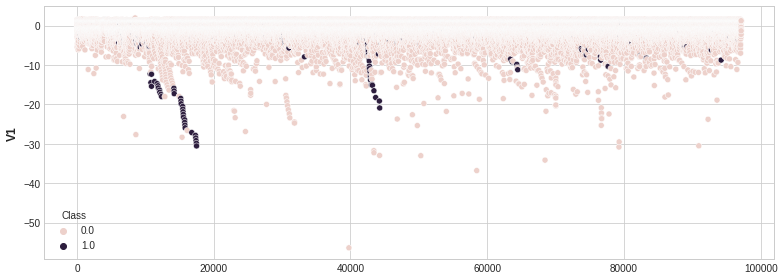

In [40]:
sns.scatterplot(data=data_df, x=data_df.index,y="V1",hue="Class")

In [42]:
# separating the data for analysis
legit = data_df[data_df.Class == 0]
fraud = data_df[data_df.Class == 1]
print(legit.shape)
print(fraud.shape)

(96919, 31)
(222, 31)


In [44]:
temp = data_df["Class"].value_counts()/data_df["Class"].count()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})
df.tail()

,Class,values
0,0.0,0.997715
1,1.0,0.002285


##Only 492 (or 0.1727%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

<AxesSubplot:xlabel='Class', ylabel='values'>

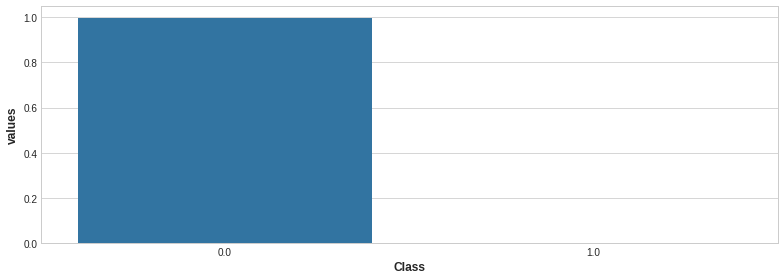

In [45]:
sns.barplot(data=df, y="values", x="Class")

## Understand time and transcation

The distribution of fraudulent transactions is more uniform compared to valid transactions, and they occur at a similar frequency throughout different time periods, including the low real transaction times during the night in the European time zone.

In [46]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

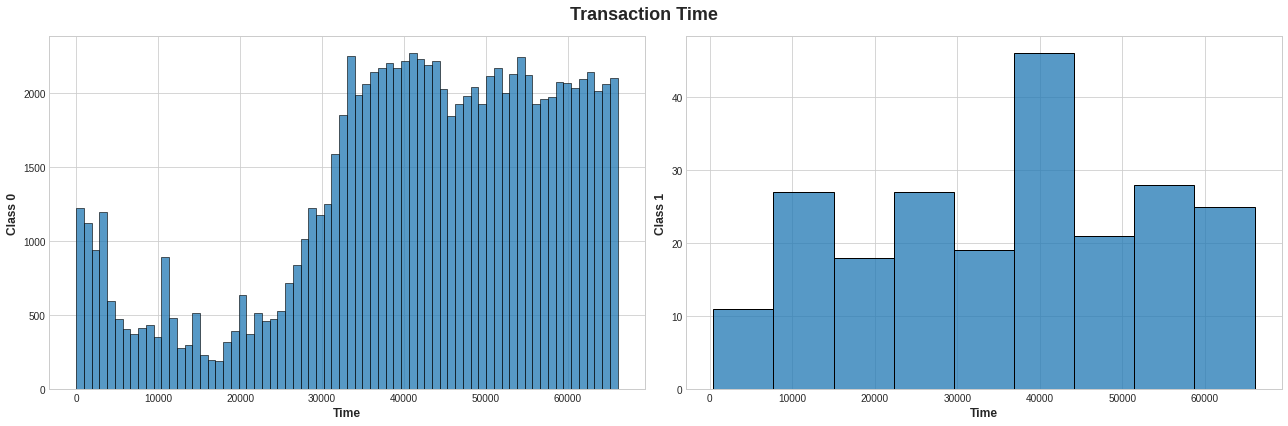

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
sns.histplot(data=class_0,ax=ax1)
sns.histplot(data=class_1,ax=ax2)
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Transaction Time")
plt.show()

In [48]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.tail()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
33,16.0,1.0,1.00,1389.56,14,2734.64,195.331429,32.310,138784.169705
34,17.0,0.0,0.00,6000.00,7870,831171.31,105.612619,24.945,74261.466948
35,17.0,1.0,0.00,1402.16,12,2916.38,243.031667,12.830,180018.846942
36,18.0,0.0,0.00,2571.80,2885,224095.34,77.676028,21.110,31137.532844
37,18.0,1.0,7.53,1354.25,5,1593.20,318.640000,98.010,336829.743400


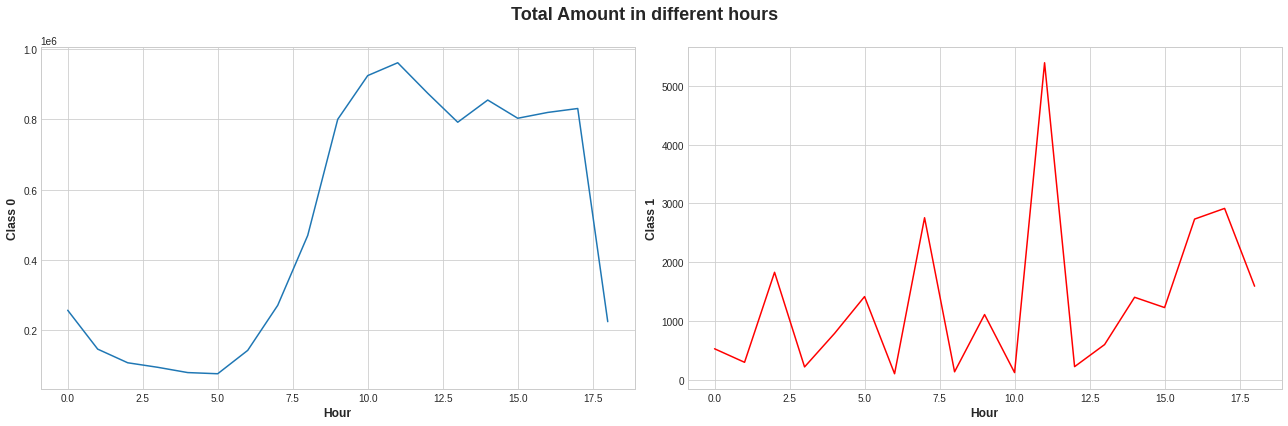

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6),sharey=False)
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Total Amount in different hours")
plt.show();

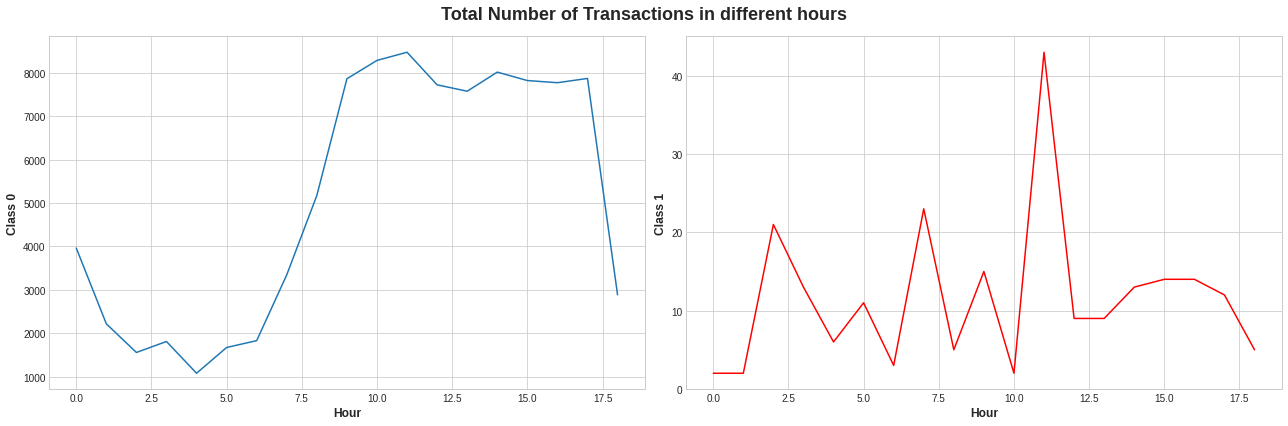

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Total Number of Transactions in different hours")
plt.show();

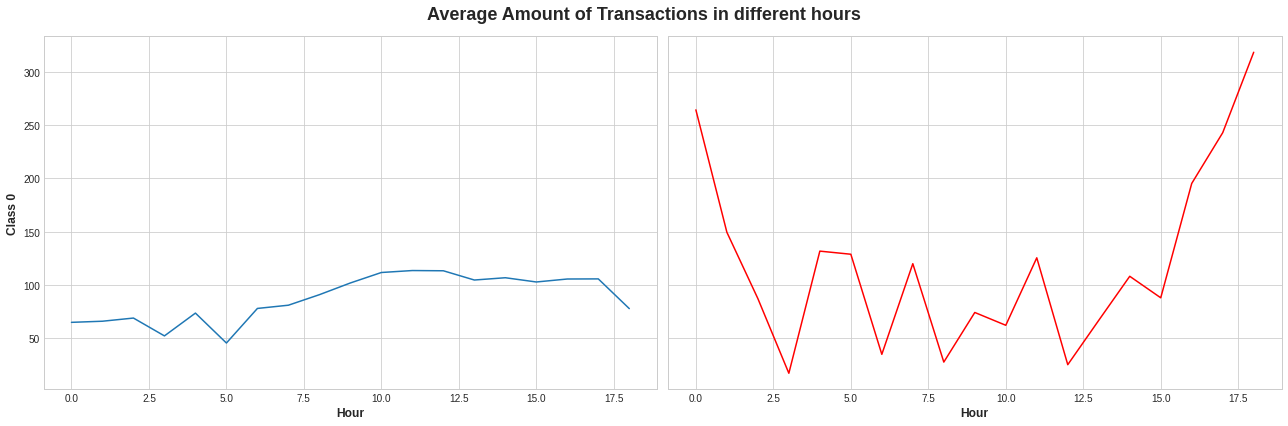

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6),sharey=True)
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Average Amount of Transactions in different hours")
plt.show();

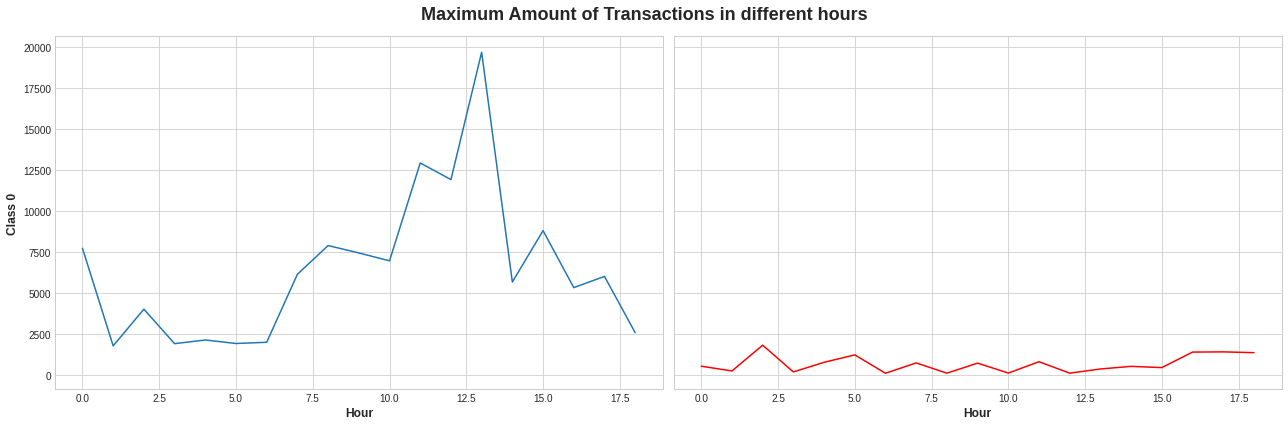

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6),sharey=True)
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Maximum Amount of Transactions in different hours")
plt.show();

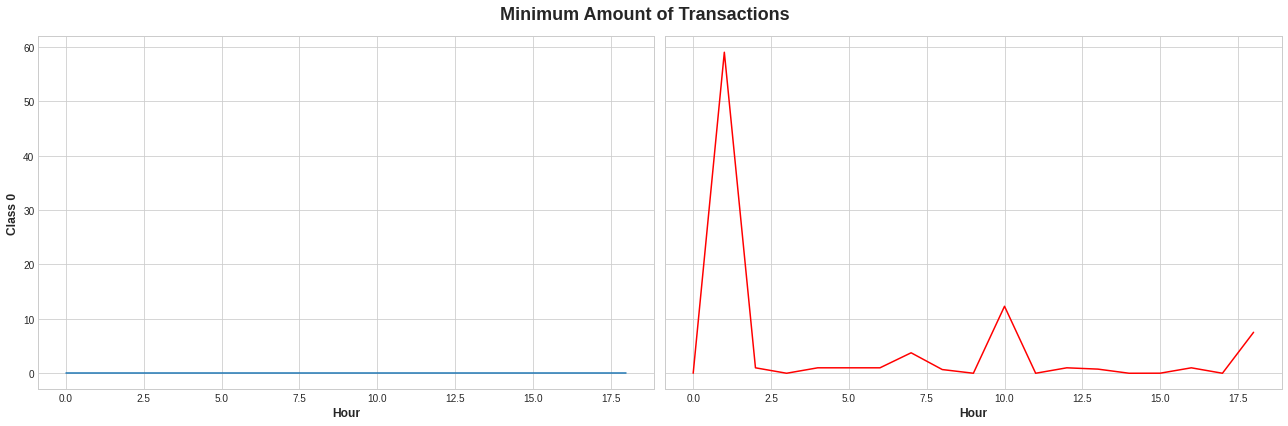

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6),sharey=True)
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
ax1.set_ylabel("Class 0")
ax2.set_ylabel("Class 1")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

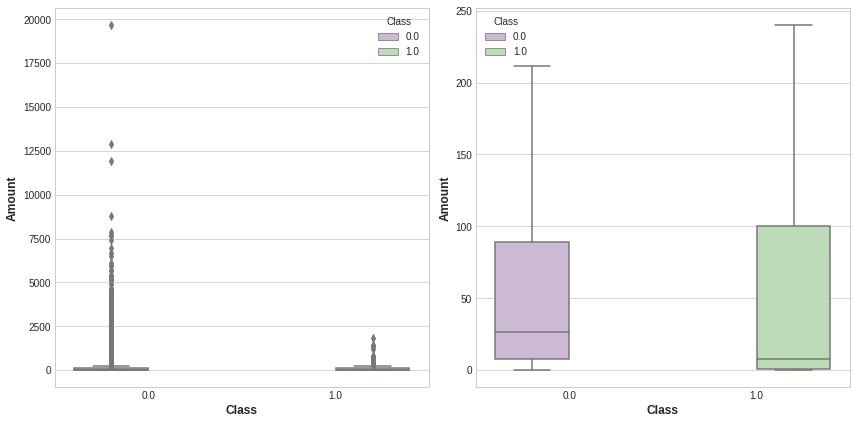

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [55]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    96919.000000
mean        98.310270
std        265.983851
min          0.000000
25%          7.580000
50%         26.610000
75%         89.345000
max      19656.530000
Name: Amount, dtype: float64

In [56]:
class_1.describe()

count     222.000000
mean      114.488243
std       255.373074
min         0.000000
25%         1.000000
50%         7.805000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

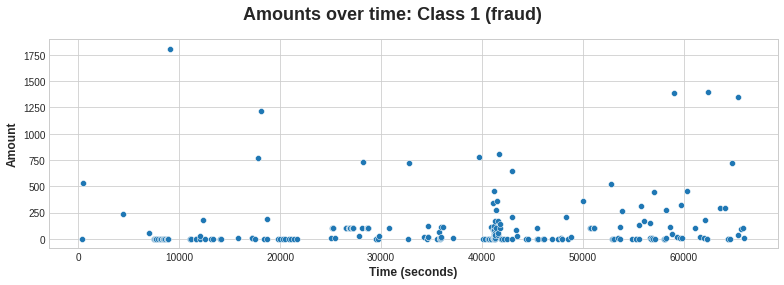

In [57]:
fraud = data_df.loc[data_df['Class'] == 1]
ax = sns.scatterplot(data=fraud,x="Time",y="Amount")
ax.set_xlabel("Time (seconds)")
plt.suptitle("Amounts over time: Class 1 (fraud)")
plt.show()

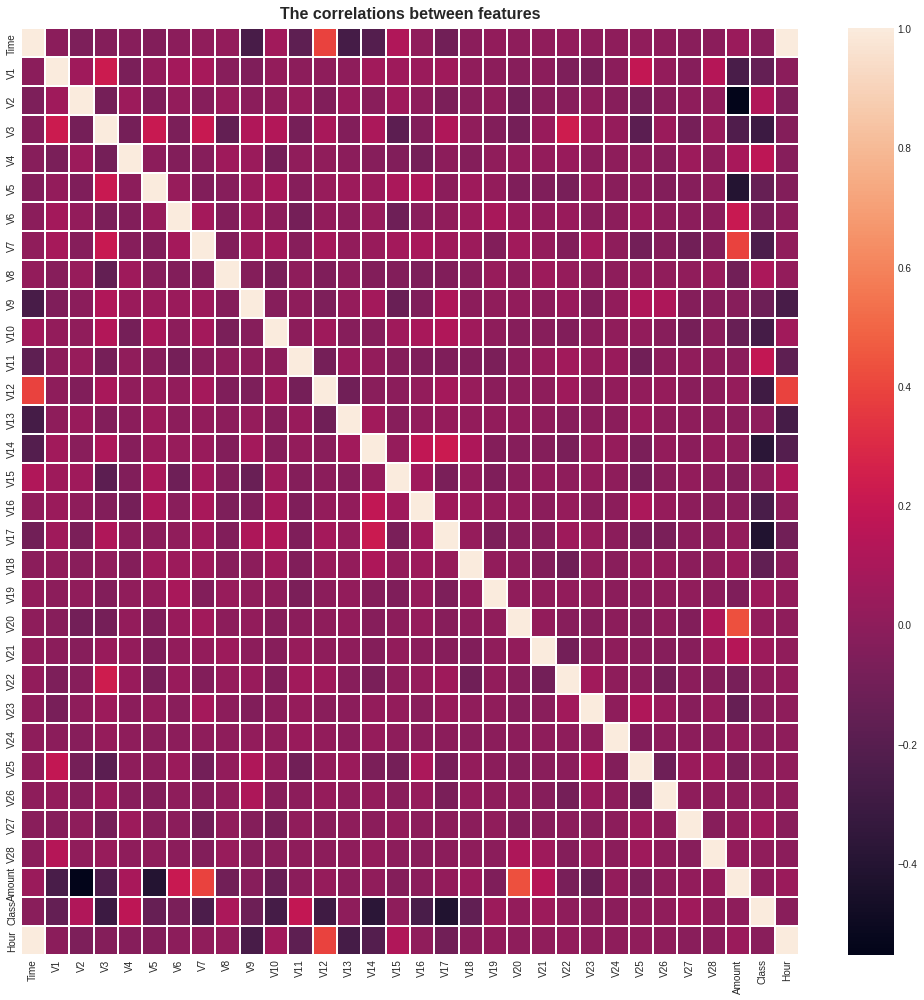

In [58]:
plt.figure(figsize = (14,14))
plt.title('The correlations between features')
corr = data_df.corr()
sns.heatmap(corr,linewidths=.1)
plt.show()

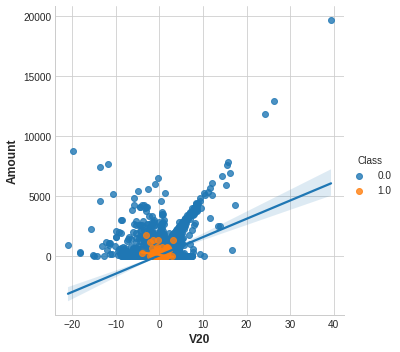

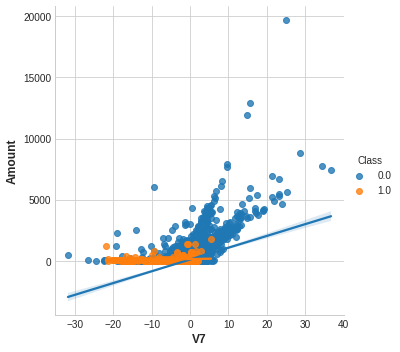

In [59]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
# Seaborn lmplot cannot take "ax" argument. We have to accept two plots in row. 
sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg= True)
sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg= True)
plt.show()

# Date preprocessing

## Missing value imputation

In [80]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#Define a subset of the dataset
df_knn = df.filter(['V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'], axis=1).copy()



In [81]:
# Define scaler to set values between 0 and 1
numColumns = df_knn.select_dtypes(include=np.number).columns.tolist()

In [82]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

In [108]:
imputer = imputer.fit(data_df[['V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount','Class']])

In [109]:
data_df[['V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount','Class']] = imputer.transform(data_df[['V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount','Class']])

In [110]:
data_df[['Amount','Class']].isnull().sum()

Amount    0
Class     0
dtype: int64

In [111]:
data_df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Hour      0
dtype: int64

# Build the models

##we will specify the predictor variables and the target variable. If applicable, any categorical variables will also be defined. In this particular case, there are no categorical variables.

In [112]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [113]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [114]:
X_train, X_valid, X_test = train_df[predictors], valid_df[predictors], test_df[predictors]
y_train, y_valid, y_test = train_df[target], valid_df[target], test_df[target]

#CatBoostClassifier
CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data.

In [118]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [119]:
clf.fit(X_train, y_train,verbose=True)

0:	total: 2.34s	remaining: 19m 27s
50:	total: 1m 13s	remaining: 10m 47s
100:	total: 2m 24s	remaining: 9m 31s
150:	total: 3m 34s	remaining: 8m 15s
200:	total: 4m 45s	remaining: 7m 4s
250:	total: 5m 53s	remaining: 5m 51s
300:	total: 7m 3s	remaining: 4m 39s
350:	total: 8m 10s	remaining: 3m 28s
400:	total: 9m 20s	remaining: 2m 18s
450:	total: 10m 30s	remaining: 1m 8s
499:	total: 11m 36s	remaining: 0us


In [120]:
preds = clf.predict(X_valid)

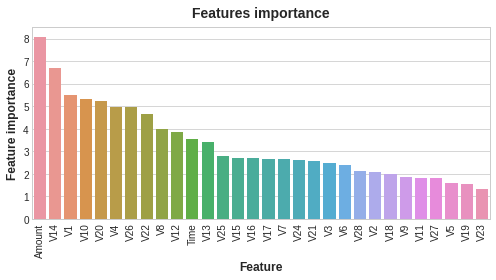

In [121]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [123]:
roc_auc_score(y_valid, preds)

0.9404761904761905

# XGBoost

In [124]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test, y_test)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [125]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[19:23:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.91244	valid-auc:0.91660
[50]	train-auc:0.92992	valid-auc:0.94033
[100]	train-auc:0.96841	valid-auc:0.98169
[150]	train-auc:0.98884	valid-auc:0.99440
[200]	train-auc:0.99522	valid-auc:0.99521
[250]	train-auc:0.99814	valid-auc:0.99731
[297]	train-auc:0.99883	valid-auc:0.99710


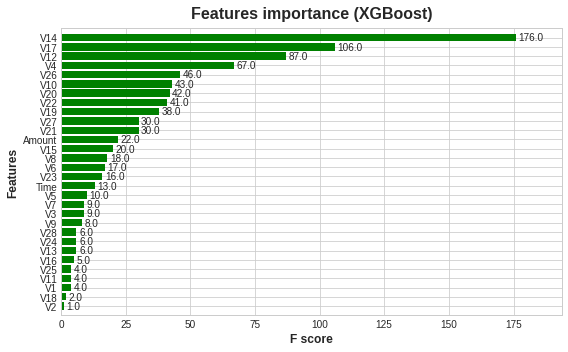

In [126]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [127]:
preds = model.predict(dtest)

In [128]:
roc_auc_score(y_test, preds)

0.9742774953170993

For CatBoostClassifier, the AUC score after training 499 iterations is 0.94 for the test data and the most important features are Amount,V14, V1, V10, V20.

For XGBoost model, the best validation score obtained was 0.97,and the most important features are V14, V17, V12, V4. 

Feature V14 contributed the most in two models. Therefore, it could have further investigation.